# Code for Stokes Local Systems


Here's some code-in-progress for visualizing and exploring moduli spaces of irregular local systems for GLn. 

## TODO:
- [x] Find Stablizers
- [ ] Find filtrations?
- [x] Compute singular (anti-stokes) directions, make a graph
- [ ] Compute Stokes directions
- [ ] Compute Stokes groups? 
- [ ] Make a nice graphic that could go in a paper?


In [26]:
def get_weight_function(Q,alpha,Laurent_ring=LaurentPolynomialRing(SR,'z')):
    """
    Given a singularity type Q,
    and root alpha, returns the function 
    defined by their composition.
    
    Inputs:
    Q dictionary {int: matrix} - defines the singularity type. Az^-1 + Bz^-3 should be written {-1:A,-3:B}
    alpha (function) - the weight, should be a function that accepts A as its only argument
    Laurent_ring -- where alpha takes values. QQ[z,z^(-1)] by default.
    
    Output:
    Laurent_ring.element - what's written alpha(Q) in Boalch's Geometry and Braiding of Stokes Data pg. 331
    
    Example:
    alpha_01 = lambda A : matrix(A)[0,0]-matrix(A)[1,1]
    Q = {-1:diagonal_matrix([1,1,2]), -3:diagonal_matrix([1,2,2])} 
    
    get_weight_function(Q,alpha_01)
    
    """
    z = Laurent_ring.gen()
    return Laurent_ring.sum([Laurent_ring(alpha(v))*z^(k) for k,v in Q.items()])
    
def get_root(i,negate=False):
    """
    This little function gets around python's poor
    behavior of list comphrension of lambdas
    
    Input:
    i int -- we want the i,i+1 weight.
    
    Output:
    lambda
    """
    if negate:
        the_root = lambda A : A[i+1,i+1]-A[i,i]
    else:
        the_root = lambda A : A[i,i]-A[i+1,i+1]
        
    return the_root

def get_simple_roots(rank):
    """
    Gets the list of simple roots for Gln
    
    Input:
    rank int - the rank n
    
    Output list[lambda] - a list of lambdas implementing the simple roots.
    
    Example:
    the_roots = get_simple_roots(4)
    [alpha(diagonal_matrix([3,1,1,6])) for alpha in the_roots]
    > [2, 0, -5]
    
    this is [3-1, 1-1, 1-6]
    """
    return [get_root(i) for i in range(rank-1)]+[get_root(i,negate=True) for i in range(rank-1)]

def get_all_simple_root_functions(Q,Laurent_ring=LaurentPolynomialRing(SR,'z')):
    """
    Gets the list of simple root functions for a given singularity type Q.
    
    Input:
    Q dict {int: matrix} -- the singularity type. the keys are the powers of z and the matrices are their coefficients.
    Laurent_ring -- what ring we want the root function to take values in. QQ[z,z^-1] by default.
    
    Example:
    Q = {-1:diagonal_matrix([5,4,1,2]), -3:diagonal_matrix([1,1,3,2])}
    get_all_simple_root_functions(Q)
    > [z^-1, -2*z^-3 + 3*z^-1, z^-3 - z^-1]
    """
    
    rank = matrix(list(Q.values())[0]).rank()
    simple_roots = get_simple_roots(rank)
    
    return [get_weight_function(Q,alpha,Laurent_ring=Laurent_ring) for alpha in simple_roots]

In [27]:
Q = {-1:diagonal_matrix([1,2,1]), -3:diagonal_matrix([1,1,2])}

#get_all_simple_root_functions(Q)

get_all_singular_directions_for_irreg_type(Q)

root_function_list:  [-z^-1, -z^-3 + z^-1, z^-1, z^-3 - z^-1]


[(-z^-1, [1]),
 (-z^-3 + z^-1, [-1/2*I*sqrt(3) - 1/2, 1, 1/2*I*sqrt(3) - 1/2]),
 (z^-1, [-1]),
 (z^-3 - z^-1, [1/2*I*sqrt(3) + 1/2, -1, -1/2*I*sqrt(3) + 1/2])]

In [3]:
A1 = diagonal_matrix([1,1,2]); A2 = diagonal_matrix([1,2,3])
CS1 = A1.column_space()

### Stablizers

In [4]:
import itertools

def find_matrix_stablizer(diag_matrix):
    rank = diag_matrix.rank()
    indices = itertools.combinations(range(rank),2)
    stab_matrix = matrix.identity(rank)
    
    for i,j in indices:
        if diag_matrix[i,i] == diag_matrix[j,j]:
            stab_matrix[i,j] = 1
            stab_matrix[j,i] = 1
            
    return stab_matrix
    
    
def find_irreg_type_stablizer(Q):
    """
    Finds the stablizers of the irregularity type Q.
    This is actually a matrix group, but we just 
    make a matrix group with 1s in the components 
    that can be non-zero. 
    
    Example:
    Q = {-1:diagonal_matrix([1,1,2,1]), -3:diagonal_matrix([1,1,3,2])}
    find_irreg_type_stablizer(Q)
    >
        [1 1 0 0]
        [1 1 0 0]
        [0 0 1 0]
        [0 0 0 1]
    """
    list_of_stablizers = []
    for A in Q.values():
        list_of_stablizers.append(find_matrix_stablizer(A))
        
    intersect_stablizers = lambda A,B : matrix([[min(A[i,j],B[i,j]) for j in range(A.ncols())] for i in range(A.nrows())])
    
    
    return reduce(intersect_stablizers,list_of_stablizers)
    

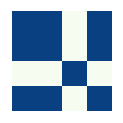

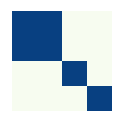

Intersection:


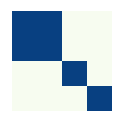

In [5]:
#find_matrix_stablizer(diagonal_matrix([1,1,2,2,1])).plot(axes=False,frame=False,cmap='GnBu',figsize=2).show()

for A in Q.values():
    find_matrix_stablizer(A).plot(frame=False,cmap='GnBu',figsize=2).show()
    
print("Intersection:")    
find_irreg_type_stablizer(Q).plot(frame=False,cmap='GnBu',figsize=2).show()

### Singular Directions

In [29]:
def get_singular_directions_for_root_function(root_function,rgbcolor=hue(.3),size=40):
    """
    Returns a plot showing the singular (or Anti-Stokes) 
    directions of a root function, which should be a laurent polynomial.
    
    Input:
    root_function (LaurentPolynomial.element) -- the root function (called q_\alpha in Boalch)
    rgbcolor -- what color to make the dots marking singular directions. default: hue(.3)
    size int -- how big the dots should be. default: 60
    include_circle bool -- whether or not to put a dashed circle on the plot. default: True
    
    Output:
    graphics primitive showing a dashed circle with points on it.
    
    Example:
    R.<z> = LaurentPolynomialRing(QQ,'z')
    qq = z^(-1)*8 + z^(-3)*3 +z^(-5)
    show_singular_directions(qq,color=hue(.1))
    > [returns a plot]
    
    """
 
    directions_list = []
    if root_function != 0:
        root_fun_dict = root_function.dict()
        degree = -1*reduce(min,root_fun_dict.keys())
        leading_coeff = root_fun_dict[-degree]
        
        directions_list = [exp(i*arg(leading_coeff))*exp((2*n+1)*pi*i/degree) for n in range(degree)]
    
    return directions_list
 



def get_all_singular_directions_for_irreg_type(Q):
    """
    Finds the singular directions for this irregularity type.
    does this by:
    1. finding the weight functions for all the simple roots.
    these are all Laurent polynomials.
    2. finding at which angles each weight function has a negative-real 
    leading (i.e. most-singular) term.
    3. plotting all those points together with a nice circle.
    
    Input:
    Q dict {int:diagonal_matrix} -- the irregularity type
    
    Output:
    plot -- a plot showing a dashed circle and all singular directions.
    
    Q = {-3:diagonal_matrix([1,1+i,4,7+3*i,exp(i*pi/3),-2*i])}
    show_all_singular_directions_for_irreg_type(Q)
    > a plot of all the singular directions.
    
    """
    root_function_list = get_all_simple_root_functions(Q)
    print("root_function_list: ",root_function_list)
    n = len(root_function_list)
    all_directions = [
        (root_function, get_singular_directions_for_root_function(root_function) )
        for root_function in root_function_list
    ]
    
    return all_directions
    
    
    
    
def show_all_singular_directions_for_irreg_type(Q):

    all_sing_directions = get_all_singular_directions_for_irreg_type(Q)
    num_roots = len(all_sing_directions)    
    
    the_plot = Graphics()
    the_plot += circle((0,0),1,linestyle='dashed',edgecolor='black',axes=False)
    
    for ii in range(num_roots):
        for direction in all_sing_directions[ii][1]:
            tmp_point = point(direction,alpha=1,size=60,rgbcolor=hue(ii/num_roots))
            the_plot += tmp_point
    
    
    return the_plot


    

root_function_list:  [-I*z^-3, (I - 3)*z^-3, (-3*I - 3)*z^-3, (-1/2*I*sqrt(3) + 3*I + 13/2)*z^-3, (1/2*I*sqrt(3) + 2*I + 1/2)*z^-3, I*z^-3, (-I + 3)*z^-3, (3*I + 3)*z^-3, (1/2*I*sqrt(3) - 3*I - 13/2)*z^-3, (-1/2*I*sqrt(3) - 2*I - 1/2)*z^-3]
root_function_list:  [-I*z^-3, (I - 3)*z^-3, (-3*I - 3)*z^-3, (-1/2*I*sqrt(3) + 3*I + 13/2)*z^-3, (1/2*I*sqrt(3) + 2*I + 1/2)*z^-3, I*z^-3, (-I + 3)*z^-3, (3*I + 3)*z^-3, (1/2*I*sqrt(3) - 3*I - 13/2)*z^-3, (-1/2*I*sqrt(3) - 2*I - 1/2)*z^-3]


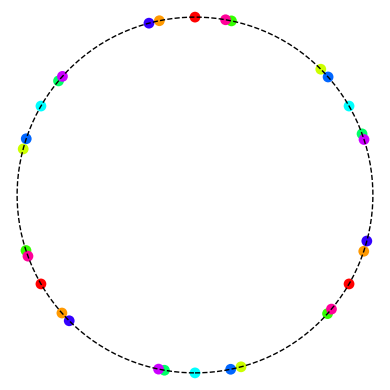

In [31]:
get_all_singular_directions_for_irreg_type(Q_long)
show_all_singular_directions_for_irreg_type(Q_long)

In [15]:
Q_long = {-3:diagonal_matrix([1,1+i,4,7+3*i,exp(i*pi/3),-2*i])}
#show_all_singular_directions_for_irreg_type(Q_long)

root_function_list:  [-z^-1, z^-1]


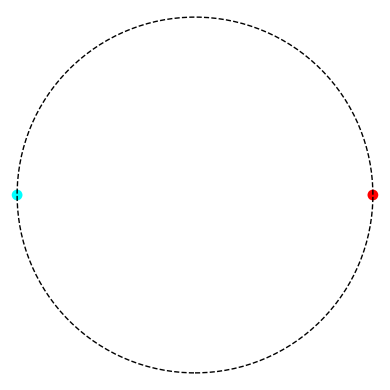

In [32]:
Q_bad = {-1:diagonal_matrix([2,3])}
show_all_singular_directions_for_irreg_type(Q_bad)

SCRATCH -- Trying to use more fancy Sage Code
--------------------------------------

In [ ]:
def construct_diagonal_matrix_space(rank,base_ring)
"""
Builds the space of rank by rank diagonal matrices over base_ring.
"""
    MS = MatrixSpace(QQ,rank,rank)
    gens_list = [MS.diagonal_matrix([0]*i+[1]+[0]*(rank-i-1)) for i in range(rank)]
    return MS.submodule(gens_list)


In [ ]:
elem = DS.from_vector(vector([1,2,3]))

In [ ]:
alpha_ij(elem.lift(),1,2)

In [ ]:
DS.__class__